In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
with open('use_preds.pkl', 'rb') as f:
    use = pickle.load(f)

with open('SBERT.pkl', 'rb') as f:
    sbert = pickle.load(f)

with open('DeepPavlov ru-SBERT.pkl', 'rb') as f:
    ru_sbert = pickle.load(f)

with open('DeepPavlov mul-SBERT.pkl', 'rb') as f:
    mul_sbert = pickle.load(f)

with open('logreg.pkl', 'rb') as f:
    logreg = pickle.load(f)

In [3]:
use_preds = np.argmax(use, axis=1)
sbert_preds = np.argmax(sbert, axis=1)
ru_sbert_preds = np.argmax(ru_sbert, axis=1)
mul_sbert_preds = np.argmax(mul_sbert, axis=1)
logreg_preds = np.argmax(logreg, axis=1)

In [4]:
df = pd.read_parquet('data/test.parquet')
labels = np.argmax(df.drop('question', axis=1).to_numpy(), axis=1)
annos = df.columns[1:]

In [5]:
col = []
for el in tqdm(use_preds):
    col.append(annos[el])

100%|██████████| 71685/71685 [00:00<00:00, 583889.58it/s]


In [57]:
answers = pd.DataFrame(columns=['true', 'use', 'sbert', 'ru_sbert', 'mul_sbert', 'logreg'], data=np.zeros((labels.shape[0], 6)))

for i, el in tqdm(enumerate(labels), total=len(labels)):
    answers.loc[i, :] = annos[el], annos[use_preds[i]], annos[sbert_preds[i]], annos[ru_sbert_preds[i]], \
        annos[mul_sbert_preds[i]], annos[logreg_preds[i]]

100%|██████████| 71685/71685 [00:08<00:00, 8461.00it/s]


In [7]:
answers.head()

,true,use,sbert,ru_sbert,mul_sbert,logreg
0,mlcourse_ai_news,theory_and_practice,mlcourse_ai_news,mlcourse_ai_news,mlcourse_ai_news,mltrainings_beginners
1,career,career,career,career,career,career
2,theory_and_practice,mltrainings_beginners,bayesian,blockchain,theory_and_practice,mltrainings_beginners
3,sequences_series,sequences_series,sequences_series,sequences_series,sequences_series,sequences_series
4,_random_talks,career,_random_talks,_random_talks,_random_talks,_random_talks


In [8]:
errors = [0, 0, 0, 0, 0]
for i, row in tqdm(answers.iterrows(), total=answers.shape[0]):
    for j, col in enumerate(row.index[1:]):
        if row['true'] != row[col]:
            errors[j] += 1

print()
print(f'Больше всего ошибок у {answers.columns[np.argmax(errors)+1]}')

100%|██████████| 71685/71685 [00:19<00:00, 3598.33it/s]
Больше всего ошибок у use



In [9]:
errors

[21987, 3750, 9556, 11101, 11536]

In [10]:
err_ids = []
for i, row in tqdm(answers.iterrows(), total=answers.shape[0]):
    err_num = 0
    for col in row.index[1:]:
        if row['true'] != row[col]:
            err_num += 1

    if err_num >= 3:
        err_ids.append(i)

100%|██████████| 71685/71685 [00:19<00:00, 3613.87it/s]


In [11]:
answers.loc[err_ids, :].head()

,true,use,sbert,ru_sbert,mul_sbert,logreg
2,theory_and_practice,mltrainings_beginners,bayesian,blockchain,theory_and_practice,mltrainings_beginners
9,career,_random_b,career,career,_random_b,_random_b
12,career,lang_python,career,deep_learning,career,lang_python
41,_random_talks,edu_books,theory_and_practice,_random_talks,theory_and_practice,_random_talks
48,career,_random_b,deephack,_random_b,_random_talks,_random_b


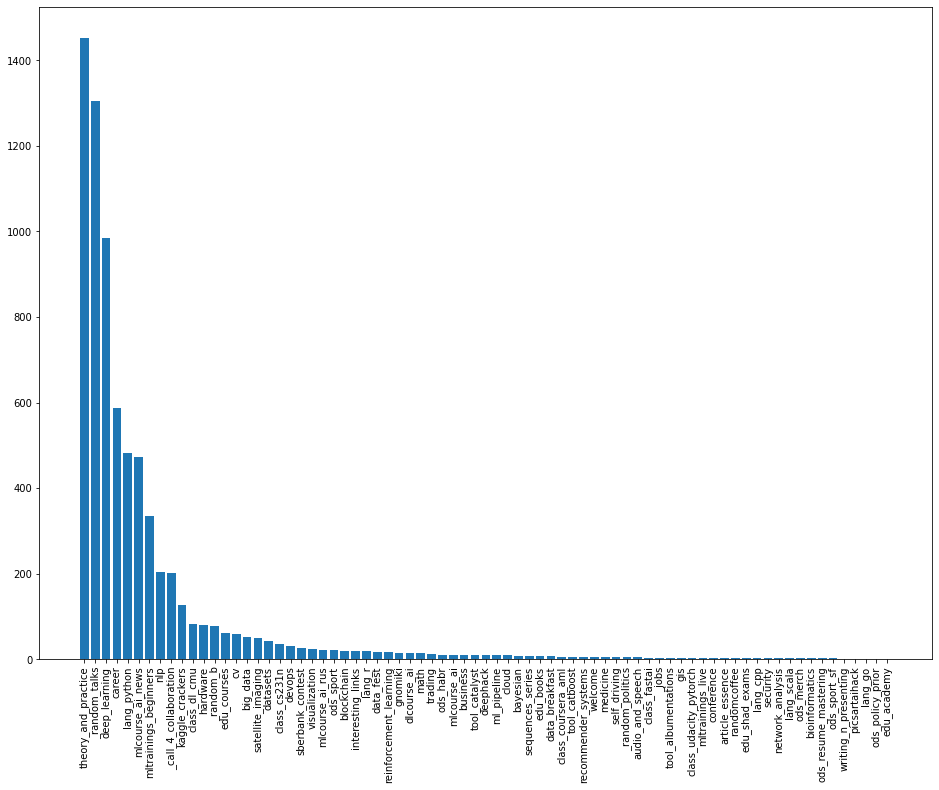

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,12))
fig = plt.bar(answers.loc[err_ids, 'true'].value_counts().index, answers.loc[err_ids, 'true'].value_counts().values)
plt.xticks(answers.loc[err_ids, 'true'].value_counts().index, answers.loc[err_ids, 'true'].value_counts().index, rotation='vertical');

Выпишем id самых частых ошибок и посмотрим на тексты

In [39]:
answers.loc[err_ids, :][answers['true'] == 'theory_and_practice'].head()

,true,use,sbert,ru_sbert,mul_sbert,logreg
2,theory_and_practice,mltrainings_beginners,bayesian,blockchain,theory_and_practice,mltrainings_beginners
108,theory_and_practice,tool_catboost,lang_python,kaggle_crackers,tool_catboost,kaggle_crackers
145,theory_and_practice,mlcourse_ai_news,theory_and_practice,deep_learning,mltrainings_beginners,mltrainings_beginners
188,theory_and_practice,deep_learning,theory_and_practice,deep_learning,deep_learning,deep_learning
191,theory_and_practice,sequences_series,theory_and_practice,lang_python,theory_and_practice,sequences_series


In [40]:
df.loc[108, 'question']

'XGBoost в режиме GPU пытается засунуть все данные в видеопамять? Иначе я не совсем понимаю, почему на небольших выборках все работает, а на больших кернел крашится (хотя ОЗУ ещё вагон, а вот видеопамяти уже нет). Сабж пикрелейтед. На LGBM и CatBoost такой проблемы не было. P.S. на CPU всё ок'

In [41]:
df.loc[2, 'question']

'Вопрос по библиотеке imbalanced learn для разбалансированной целевой переменной. Не совсем понял, как пользоваться. Предположим, выровнял миноритарный класс с мажоритарным одним из методов under-sampling или over-sampling. А дальше? Обучать модель на этих данных (сбалансированных по целевой переменной), а предикты выдавать на разбалансированных? Или как-то иначе?'

In [42]:
df.loc[191, 'question']

'Всем привет!  Прошу совета. \nЕсть многомерный временной ряд, поведение которого считается нормой. Необходимо для других временных рядов определить случаи отклонения от этой нормы. Кажется, такие методы, как k-means, LocalOutlierFactor и подобные, не очень подходят, так как они нацелены на поиск аномалий и кластеризацию в заданном временном ряду, в то время как мне нужно выявить отклонение поведения от «нормального ряда». Может существуют какие-нибудь еще методы?\n\nСпасибо. '

In [15]:
tp_num = answers['true'].value_counts()['theory_and_practice']
rt_num = answers['true'].value_counts()['_random_talks']
dl_num = answers['true'].value_counts()['deep_learning']
car_num = answers['true'].value_counts()['career']
py_num = answers['true'].value_counts()['lang_python']

In [27]:
topicks = ['theory_and_practice', '_random_talks', 'deep_learning', 'career', 'lang_python']
rel_errors = {
    'theory_and_practice': [0, 0, 0, 0, 0],
    '_random_talks': [0, 0, 0, 0, 0],
    'deep_learning': [0, 0, 0, 0, 0],
    'career': [0, 0, 0, 0, 0],
    'lang_python': [0, 0, 0, 0, 0],
}
for i, row in tqdm(answers.iterrows(), total=answers.shape[0]):
    if row['true'] in topicks:
        for j, col in enumerate(row.index[1:]):
            if row['true'] != row[col]:
                rel_errors[row['true']][j] += 1


for key, value in rel_errors.items():
    value[0] = (value[0]/tp_num)*100
    value[1] = (value[1]/rt_num)*100
    value[2] = (value[2]/dl_num)*100
    value[3] = (value[3]/car_num)*100
    value[4] = (value[4]/py_num)*100

rel_errors

100%|██████████| 71685/71685 [00:11<00:00, 6028.34it/s]


{'theory_and_practice': [65.85629389519178,
  7.290762554246745,
  21.445042275172945,
  11.73662676163055,
  52.252906976744185],
 '_random_talks': [98.75742841707186,
  7.241165530068196,
  16.14142966948501,
  12.04727989089256,
  48.837209302325576],
 'deep_learning': [58.328831262380696,
  5.2820830750155,
  17.970791698693315,
  8.31186543415669,
  43.77422480620155],
 'career': [34.23374752386098,
  3.075015499070056,
  18.370484242890083,
  10.486437338990756,
  38.54166666666667],
 'lang_python': [23.26670268323429,
  3.273403595784253,
  7.794004611837048,
  5.008334596150932,
  20.857558139534884]}

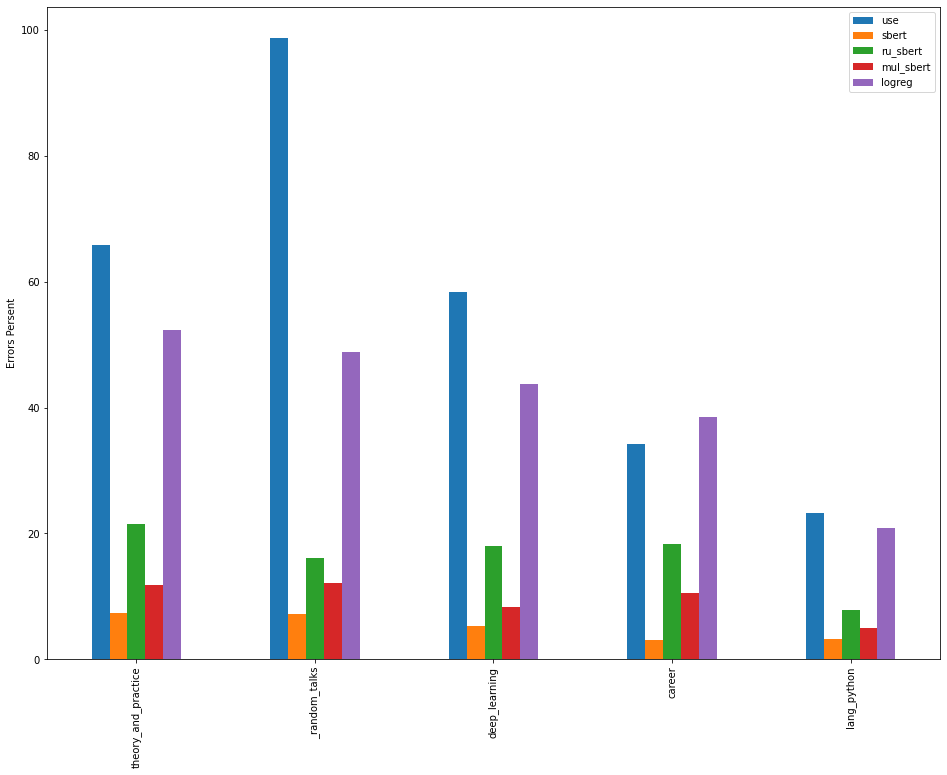

In [44]:
import seaborn as sns

data = pd.DataFrame(index=rel_errors.keys(), columns=answers.columns[1:], data=rel_errors.values())
ax = data.plot(kind='bar', figsize=(16,12))
ax.set_ylabel('Errors Persent');

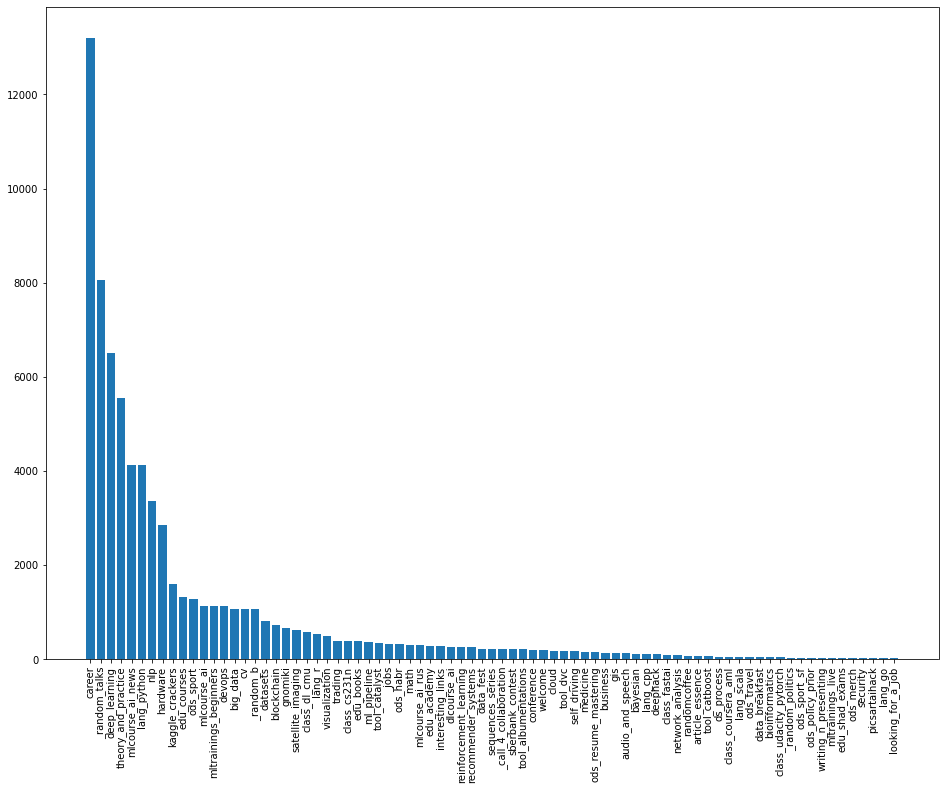

In [45]:
fig = plt.figure(figsize=(16,12))
fig = plt.bar(answers.loc[:, 'true'].value_counts().index, answers.loc[:, 'true'].value_counts().values)
plt.xticks(answers.loc[:, 'true'].value_counts().index, answers.loc[:, 'true'].value_counts().index, rotation='vertical');

In [50]:
answers.loc[:, 'true'][(answers['true'] == 'theory_and_practice') | (answers['true'] == 'career')].index

Int64Index([    1,     2,     9,    11,    12,    15,    19,    20,    22,
               27,
            ...
            71653, 71657, 71661, 71663, 71665, 71670, 71677, 71679, 71680,
            71684],
           dtype='int64', length=18751)

In [56]:
answers_num = pd.DataFrame(columns=['true', 'use', 'sbert', 'ru_sbert', 'mul_sbert', 'logreg'], data=np.zeros((labels.shape[0], 6)))

for i, el in tqdm(enumerate(labels), total=len(labels)):
    answers_num.loc[i, :] = el, use_preds[i], sbert_preds[i], ru_sbert_preds[i], mul_sbert_preds[i], logreg_preds[i]

100%|██████████| 71685/71685 [00:08<00:00, 7976.30it/s]


In [71]:
annos[60]

'ods_travel'

In [83]:
from sklearn.metrics import roc_auc_score

scores = []
for label in tqdm(answers_num.loc[:, 'true'].value_counts().index, total=len(answers_num.loc[:, 'true'].value_counts().index)):
    y_true = answers_num.loc[:, 'true'][(answers_num['true'] == 70) | (answers_num['true'] == label)]
    y_use = answers_num.loc[answers.loc[:, 'true'][(answers_num['true'] == 70) | (answers_num['true'] == label)].index, 'use']
    try:
        scores.append(roc_auc_score(y_true, y_use))
    except ValueError:
        #print(f'Error at {annos[label]}')
        continue

100%|██████████| 79/79 [00:00<00:00, 208.88it/s]


In [84]:
scores

[0.9284972276821516,
 0.8836583923459101,
 0.7474643270570105,
 0.5857566068000185,
 0.6603228691593483,
 0.5227823760354094,
 0.7343623166762083,
 0.7109929709457393,
 0.7432861510873316,
 0.4593534673008407,
 0.5953218691679967,
 0.4486672438226178,
 0.7587428295307658,
 0.9288573300821441,
 0.8753544277426439,
 0.9710105448881368,
 0.8329604154857047,
 0.951575675630462,
 0.737519525648465,
 0.525025931642387,
 0.7350387363754336,
 0.6201185512368658,
 0.879736783128656,
 0.952211534893991,
 0.714830327052485,
 0.7462630490437974,
 0.6528972748952123,
 0.9194225772426745,
 0.9976423000734184,
 0.4775782574269879,
 0.6165330646692072,
 0.557992757749646,
 0.7519700874248844,
 0.7213925548609503,
 0.7118393852807273,
 0.4369246112753851,
 0.4423734918062309,
 0.8729575339169293,
 0.9702203566636044,
 0.419010855592651,
 0.49626536540141797,
 0.9226845784467553,
 0.9439972675892451,
 0.9360016055146562,
 0.9249434739980391,
 0.9706746353322527,
 0.43156276305705277,
 0.6145716663811696

In [85]:
sum(scores)/len(scores)

0.7282677208596705

In [100]:
roc_auc_score(labels, use, average='macro', multi_class='ovr')

0.9859338905184573

In [101]:
roc_auc_score(labels, use, average='macro', multi_class='ovo')

0.9848252771690963

In [103]:
roc_auc_score(labels, use, average='macro', multi_class='ovo')

0.9751027618122916

In [104]:
roc_auc_score(labels, sbert, average='macro', multi_class='ovo')

0.9943215141325539

In [134]:
roc_auc_score(labels, np.nan_to_num(ru_sbert, nan=1/79), average='macro', multi_class='ovo')

0.9844478040134026

In [135]:
roc_auc_score(labels, np.nan_to_num(mul_sbert, nan=1/79), average='macro', multi_class='ovo')

0.9852986478926679

In [112]:
roc_auc_score(labels, logreg, average='macro', multi_class='ovo')

0.9971492247187109